In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
import matplotlib.pyplot as plt # visualization

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# This notebook produces the model with 0.78229 prediction score. 
# In other words, we accurately predict 327 out of 418 survivors. 

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Upload training and test data. 

In [2]:
training = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN

all_data = pd.concat([training, test]) 

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  train_test   1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.2+ KB


## The Analysis (EDA) of the features

From the above info, we see that there are missing variables in the columns 'Age', 'Fare', 'Cabin' and 'Embarked'. 

In [3]:
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [4]:
# we go ahead, and create numeric values for gender, and remove Sex column
training['gender'] = np.where(training['Sex'] == 'male', 0,1)
all_data['gender'] = np.where(all_data['Sex'] == 'male', 0,1)
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0


In [5]:
training.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
 13  gender       891 non-null    int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 97.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------  

In [6]:
# We first get rid of the missing Embarked rows in training set as there are only 2 of such. 
all_data.dropna(subset = ['Embarked'], inplace = True)
training.dropna(subset = ['Embarked'], inplace = True)

# We also replace the missing Fare value in the test (contained in all_data) dataset 
# by the mean of the training set. 
all_data.Fare = all_data.Fare.fillna(training.Fare.mean())

I also noticed that Fare column is showing the total amount paid for all people in one ticket. As an example, there are families who paid 69.55 for 11 tickets, which amounts to ~6.3 per ticket. The example of such family is given below, and, unfortunately, it seems none of them survived. 

As a result, we create a new column 'fare_upd', which shows the average amount paid for each person according to the formula 
**fare_upd = Fare of Ticket/Number of people in the ticket**

In [7]:
print(all_data[all_data['Ticket'].str.contains(' 2343')])

     PassengerId  Survived  Pclass                               Name     Sex  \
159          160       0.0       3         Sage, Master. Thomas Henry    male   
180          181       0.0       3       Sage, Miss. Constance Gladys  female   
201          202       0.0       3                Sage, Mr. Frederick    male   
324          325       0.0       3           Sage, Mr. George John Jr    male   
792          793       0.0       3            Sage, Miss. Stella Anna  female   
846          847       0.0       3           Sage, Mr. Douglas Bullen    male   
863          864       0.0       3  Sage, Miss. Dorothy Edith "Dolly"  female   
188         1080       NaN       3                    Sage, Miss. Ada  female   
342         1234       NaN       3              Sage, Mr. John George    male   
360         1252       NaN       3        Sage, Master. William Henry    male   
365         1257       NaN       3     Sage, Mrs. John (Annie Bullen)  female   

      Age  SibSp  Parch    

In [8]:
def fareValue(x):
    return all_data[all_data.PassengerId == x].fare_upd.mean()

In [9]:
all_data['ticket_multiple'] = all_data.Ticket.apply(lambda x: all_data['Ticket'].value_counts()[x])
#all_data['fare_upd'] = all_data.apply(lambda x: all_data['Fare']/all_data['ticket_multiple'], axis = 1)
all_data['fare_upd'] = all_data['Fare']/all_data['ticket_multiple']
training['fare_upd'] = training.PassengerId.apply(lambda x: fareValue(x))

We also add columns for Embarked ports.

In [10]:
training = pd.get_dummies(training, prefix=['Embarked'], columns=['Embarked'])

In [11]:
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test,gender,fare_upd,Embarked_C,Embarked_Q,Embarked_S
count,889.000000,889.000000,889.000000,712.000000,889.000000,889.000000,889.000000,889.0,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,29.642093,0.524184,0.382452,32.096681,1.0,0.350956,14.493836,0.188976,0.086614,0.724409
std,256.998173,0.486260,0.834700,14.492933,1.103705,0.806761,49.697504,0.0,0.477538,13.536442,0.391710,0.281427,0.447063
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800,1.0,0.000000,7.495800,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0,0.000000,8.050000,0.000000,0.000000,1.000000
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0,1.000000,13.500000,0.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0,1.000000,128.082300,1.000000,1.000000,1.000000


             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005028 -0.035330  0.033681 -0.057686 -0.001657   
Survived       -0.005028  1.000000 -0.335549 -0.082446 -0.034040  0.083151   
Pclass         -0.035330 -0.335549  1.000000 -0.365902  0.081656  0.016824   
Age             0.033681 -0.082446 -0.365902  1.000000 -0.307351 -0.187896   
SibSp          -0.057686 -0.034040  0.081656 -0.307351  1.000000  0.414542   
Parch          -0.001657  0.083151  0.016824 -0.187896  0.414542  1.000000   
Fare            0.012703  0.255290 -0.548193  0.093143  0.160887  0.217532   
train_test           NaN       NaN       NaN       NaN       NaN       NaN   
gender         -0.043136  0.541585 -0.127741 -0.099037  0.116348  0.247508   
fare_upd        0.006201  0.284632 -0.761487  0.308657 -0.071829 -0.034589   
Embarked_C     -0.001208  0.169966 -0.245733  0.038268 -0.060074 -0.011588   
Embarked_Q     -0.033694  0.004536  0.220558 -0.021693 -0.026692

<AxesSubplot:>

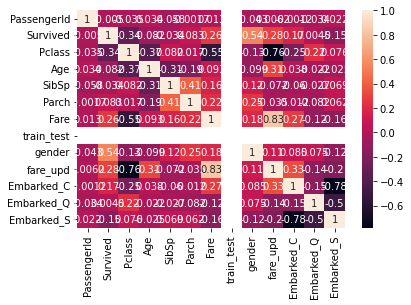

In [12]:
print(training.corr())  # check the correlation matrix and the heatmap
sns.heatmap(training.corr(), annot=True) 

From the correlation matrix we see that there are definitely several *moderate* correllation pairs like ('Pclass', 'Survived'), ('Parch', 'SibSp') etc. 
The 'Survived' column, according to the heatmap, most likely depends on 'Pclass', 'fare_upd' and 'gender'.

One thing to note is that the new feature 'fare_upd' is highly correlated with 'Pclass', so it would be wise to remove one of 'Pclass' or 'fare_upd' features. Later, I chose to remove the feature related to the fare, and noticed it gives better prediction rather than when we keep it.

We also compute **Variance Inflation Factor (VIF)** and note that Embarked_S has high variance inflation factor, so we remove it and compute VIF again to rule out any further multi-collinearity. 

In [13]:
# Code to compute Variance Inflation Factor.

from statsmodels.stats.outliers_influence import variance_inflation_factor

training_num = training[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'fare_upd', 
                         'gender', 'Embarked_Q', 'Embarked_C']]
training_num.dropna(inplace = True)
vif_data = pd.DataFrame()
vif_data["feature"] = training_num.columns
vif_data["VIF"] = [variance_inflation_factor(training_num.values, i)
                          for i in range(len(training_num.columns))]
print(vif_data)

      feature       VIF
0    Survived  2.541410
1      Pclass  3.611678
2         Age  4.932790
3       SibSp  1.601088
4       Parch  1.559921
5    fare_upd  3.422828
6      gender  2.355546
7  Embarked_Q  1.069530
8  Embarked_C  1.445238


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Next, we plot **the pairwise plot** to visually see any relations between pairs. 

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


<Figure size 800x640 with 0 Axes>

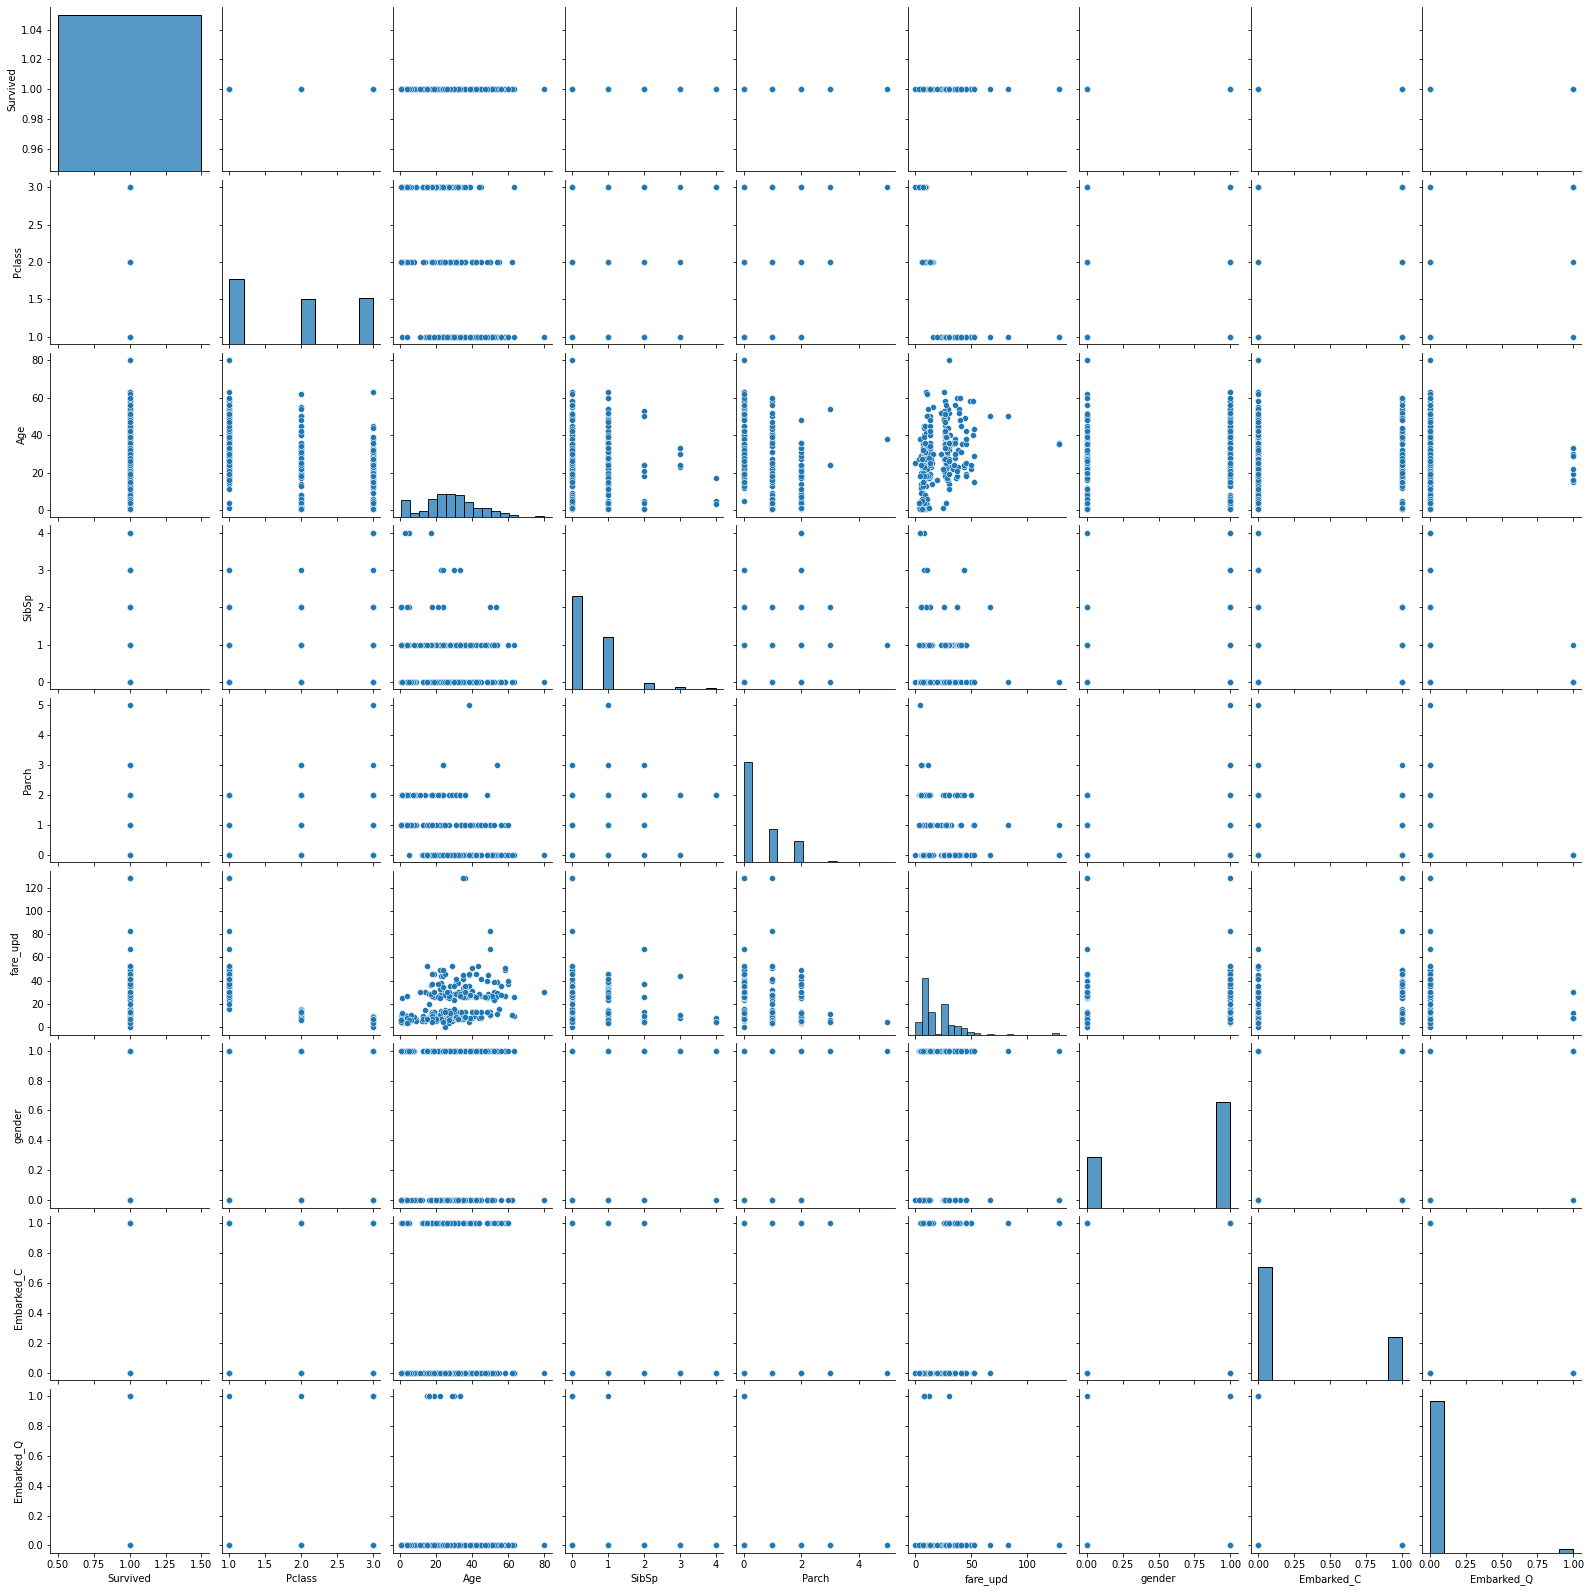

In [14]:
training_num = training[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'fare_upd', 'gender', 'Embarked_C', 'Embarked_Q']]
training_num.dropna(inplace = True)

training_num_surv = training_num[training_num.Survived==1]
training_num_Notsurv = training_num[training_num.Survived==0]

plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(training_num_surv) # pairwise plot of numeric data for Survived passengers
plt.show()

<Figure size 800x640 with 0 Axes>

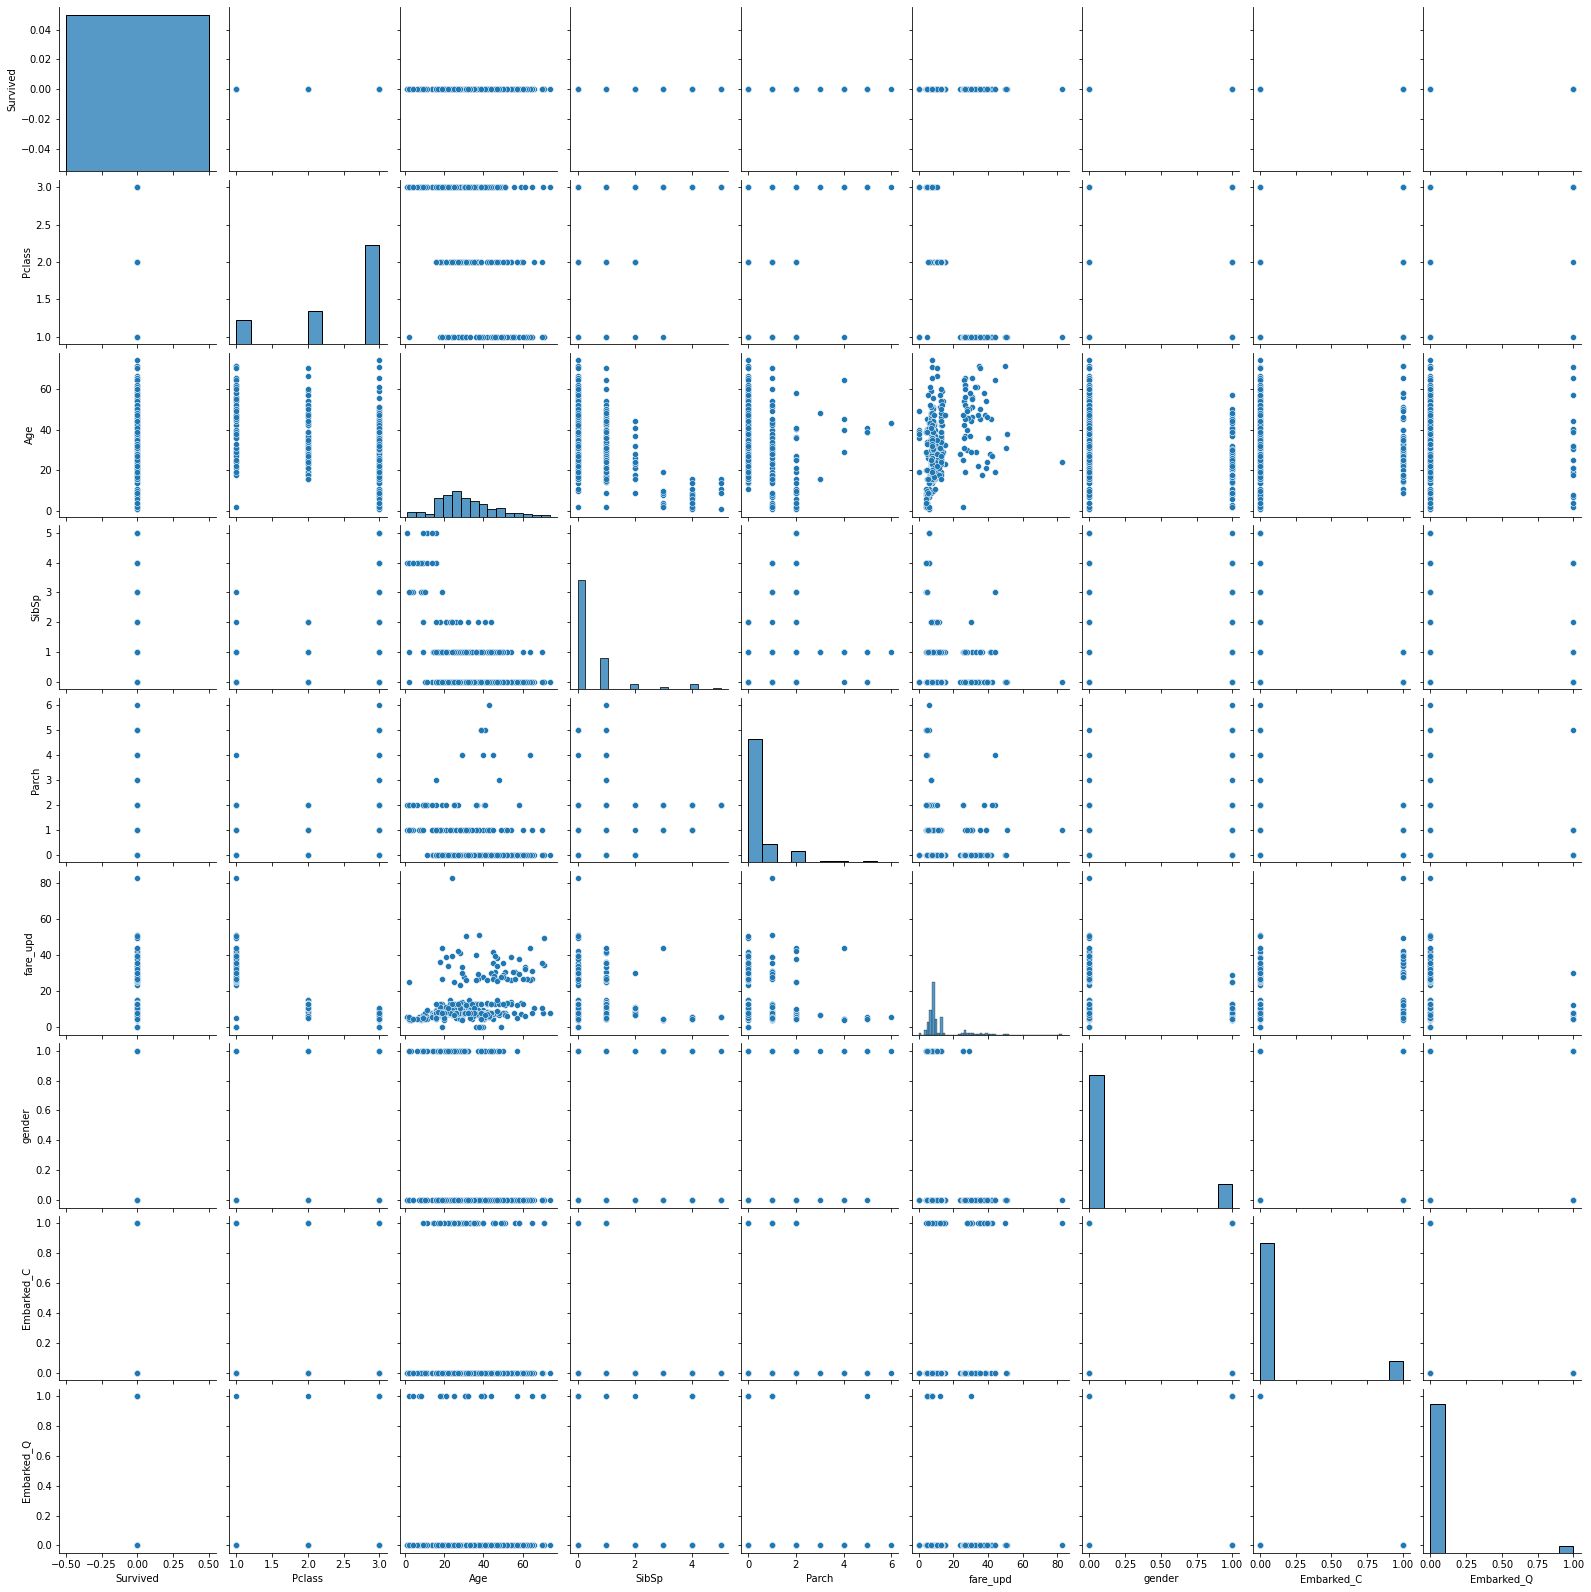

In [15]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(training_num_Notsurv) # pairwise plot of numeric data for passengers who did not survive
plt.show()

All the correlations we saw in the heatmap are also seen in the above plots. This may look a bit too messy though.

Next, we replace missing/null data in the column 'Age' by the mean value with respect to the their titles. For example, a person with a title "Master" is most likely a baby, toddler or pre-teen aged male. All computations are done in training dataset, and later translated to all_data. 
#### Please let me know if there is a better/faster way to do this!

We apply this step based on the following titles: "Master", "Miss", "Mrs", "Mr" and others (like "Capt", "Jonkheer" etc). One can, of course, can do more work here, but I found this to be sufficient. 

In [16]:
print(training[training['Name'].str.contains('Master')].head(5)) # verification of the previous statement

    PassengerId  Survived  Pclass                                Name   Sex  \
7             8         0       3      Palsson, Master. Gosta Leonard  male   
16           17         0       3                Rice, Master. Eugene  male   
50           51         0       3          Panula, Master. Juha Niilo  male   
59           60         0       3  Goodwin, Master. William Frederick  male   
63           64         0       3               Skoog, Master. Harald  male   

     Age  SibSp  Parch   Ticket     Fare Cabin  train_test  gender  fare_upd  \
7    2.0      3      1   349909  21.0750   NaN           1       0  4.215000   
16   2.0      4      1   382652  29.1250   NaN           1       0  4.854167   
50   7.0      4      1  3101295  39.6875   NaN           1       0  5.669643   
59  11.0      5      2  CA 2144  46.9000   NaN           1       0  5.862500   
63   4.0      3      2   347088  27.9000   NaN           1       0  4.650000   

    Embarked_C  Embarked_Q  Embarked_S  
7  

In [17]:
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
training['name_title'].value_counts()

Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: name_title, dtype: int64

In [18]:
def age_func(x):   # create the function, which assigns 'Age' values when it is missing/null 
    if x == 'Mr':
        return training.loc[training['name_title'] == 'Mr'].Age.mean()
        #return training_Mr.Age.mean()
    if x == 'Mrs':
        return training.loc[training['name_title'] == 'Mrs'].Age.mean()
        # return training_Mrs.Age.mean()
    if x == 'Master': 
        return training.loc[training['name_title'] == 'Master'].Age.mean()
        # return training_Master.Age.mean()
    if x == 'Miss':
        return training.loc[training['name_title'] == 'Miss'].Age.mean()
        # return training_Miss.Age.mean()
    else:
        return training.loc[~training['Age'].isna()].Age.mean()
        #return training_all.Age.mean()

In [19]:
# training['age_mean'] = training.name_title.apply(lambda x: age_func(x))
training['age_upd'] = np.where(training['Age'].isna(), training.name_title.apply(lambda x: age_func(x)), training['Age'])
all_data['age_upd'] = np.where(all_data['Age'].isna(), all_data.name_title.apply(lambda x: age_func(x)), all_data['Age'])
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  train_test   889 non-null    int64  
 12  gender       889 non-null    int64  
 13  fare_upd     889 non-null    float64
 14  Embarked_C   889 non-null    uint8  
 15  Embarked_Q   889 non-null    uint8  
 16  Embarked_S   889 non-null    uint8  
 17  name_title   889 non-null    object 
 18  age_upd      889 non-null    float64
dtypes: float

In [20]:
print(pd.pivot_table(training, index = 'Survived', values = ['Pclass', 'age_upd', 'SibSp', 'Parch', 'fare_upd', 'gender']))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Pclass', values = 'train_test', aggfunc = 'count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'gender', values = 'train_test', aggfunc = 'count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked_C', values = 'train_test', aggfunc = 'count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked_Q', values = 'train_test', aggfunc = 'count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked_S', values = 'train_test', aggfunc = 'count'))


             Parch    Pclass     SibSp    age_upd   fare_upd    gender
Survived                                                              
0         0.329690  2.531876  0.553734  30.661515  11.463456  0.147541
1         0.467647  1.955882  0.476471  28.110871  19.387009  0.679412

Pclass      1   2    3
Survived              
0          80  97  372
1         134  87  119

gender      0    1
Survived          
0         468   81
1         109  231

Embarked_C    0   1
Survived           
0           474  75
1           247  93

Embarked_Q    0   1
Survived           
0           502  47
1           310  30

Embarked_S    0    1
Survived            
0           122  427
1           123  217


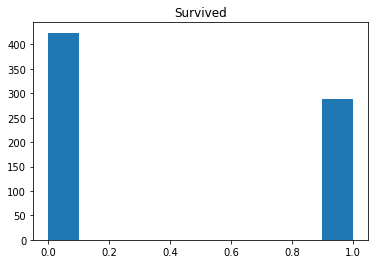

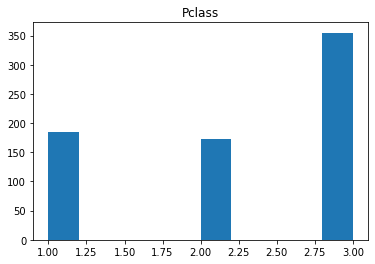

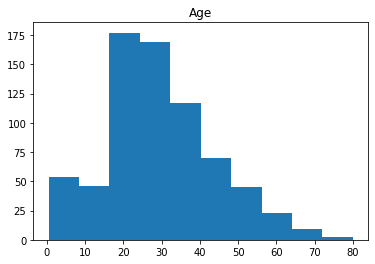

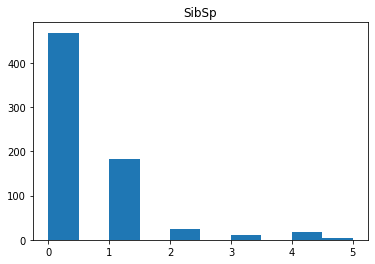

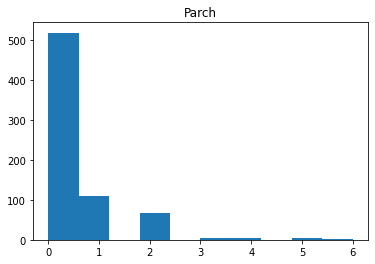

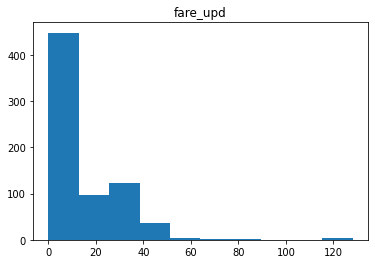

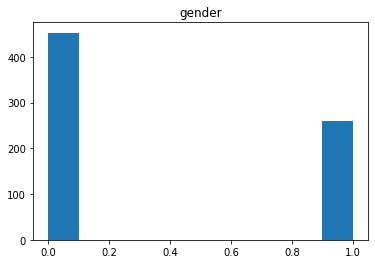

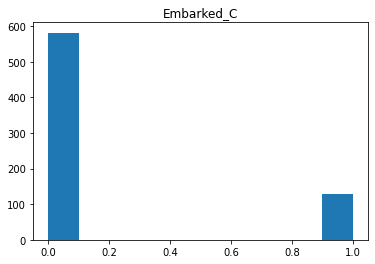

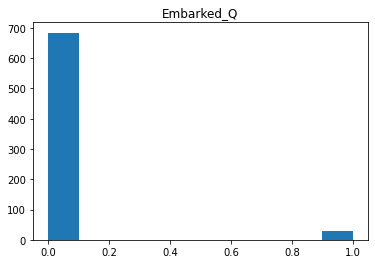

In [21]:
for j in training_num.columns:
    plt.hist(training_num[j])
    plt.title(j)
    plt.show()

The 'fare_upd' data is not normally distributied, so we apply log-transformation to it.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

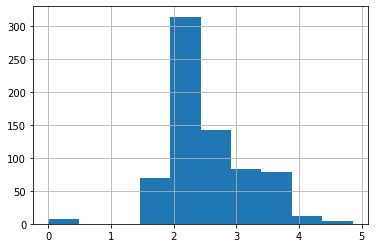

In [22]:
training_num['norm_fare_upd'] = np.log(training_num.fare_upd+1)
training_num['norm_fare_upd'].hist()

In [23]:
training['norm_fare_upd'] = np.log(training.fare_upd+1)
all_data['norm_fare_upd'] = np.log(all_data.fare_upd+1)

## Training the model

We ignore 'Ticket' and 'Cabin' columns for now. To be honest, I don't see how the ticket values can be used as they are all different and there is no clear pattern/order there. 

The 'Cabin' can be somehow analyzed though. This to be added in the future versions. One can also perform the hyperparameter tuning and combine 'SibSp' with 'Parch' features. Such steps allowed me to get the model producing my current highest score of 0.78468. I am planning to include this all in the future versions. 

I tried several machine learning models, and Support Vector machines gives the best result. 

In [24]:
all_data_used = pd.get_dummies(all_data[['Pclass', 'SibSp', 'Parch', 'gender', 
                                        'age_upd', 'Embarked', 'train_test']])
#all_data_used = pd.get_dummies(all_data[['Pclass', 'gender', 'norm_fare_upd', 
#                                        'age_upd', 'Embarked', 'train_test']])
all_data_used = all_data_used.drop(['Embarked_S'], axis = 1)
all_data_used.head()

,Pclass,SibSp,Parch,gender,age_upd,train_test,Embarked_C,Embarked_Q
0,3,1,0,0,22.0,1,0,0
1,1,1,0,1,38.0,1,1,0
2,3,0,0,1,26.0,1,0,0
3,1,1,0,1,35.0,1,0,0
4,3,0,0,0,35.0,1,0,0


In [25]:
X_train = all_data_used[all_data_used.train_test==1].drop(['train_test'], axis = 1)
X_test = all_data_used[all_data_used.train_test==0].drop(['train_test'], axis = 1)
y_train = all_data[all_data.train_test==1].Survived

In [26]:
# Scale the data

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_data_used.copy()
#all_dummies_scaled[['age_upd', 'norm_fare_upd']] = scale.fit_transform(all_dummies_scaled[['age_upd', 
#                                                                                           'norm_fare_upd']])
all_dummies_scaled[['age_upd']] = scale.fit_transform(all_dummies_scaled[['age_upd']])
X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test==1].drop(['train_test'], axis = 1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test==0].drop(['train_test'], axis = 1)
y_train = all_data[all_data.train_test==1].Survived

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [28]:
svc = SVC(probability = True)
cv = cross_val_score(svc, X_train_scaled, y_train, cv = 5)
print(cv)
print(cv.mean())
svc.fit(X_train_scaled, y_train)
y_final_svc = svc.predict(X_test_scaled).astype(int)

[0.83707865 0.8258427  0.81460674 0.80898876 0.84180791]
0.8256649527074208


In [29]:
rf = RandomForestClassifier(random_state=42)
cv = cross_val_score(rf, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())
rf.fit(X_train_scaled, y_train)
y_final_rf = rf.predict(X_test_scaled).astype(int)

[0.74719101 0.79213483 0.81460674 0.79213483 0.82485876]
0.7941852345584968


In [30]:
gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=100)
cv = cross_val_score(gb, X_train_scaled, y_train, cv = 5)
print(cv.mean())
gb.fit(X_train_scaled, y_train)
y_final_gb = gb.predict(X_test_scaled).astype(int)

0.8121754586427983


In [31]:
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
#submission

In [32]:
submission['Survived'] = y_final_svc
submission.to_csv('submission.csv', index = False)
#pd.read_csv('submission.csv')

## Future plans:

* Include 'Cabin' into consideration. 
* Combine 'SibSp' and 'Parch' features. There variables are not highly corellated, so it is not intuitive combining them I believe. However, I noticed in other notebooks that creating a new feature of type 'SibSp' + 'Parch' + 1 improves the model.
* Perform hyperparameter tuning.
* Try other ML models. May be, Neural Networks produce better results?